<a href="https://colab.research.google.com/github/vikash-singhaniya/max-healthcare-noisy-label-derm-cnn/blob/main/Max_Healthcare_Assignment_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Max Healthcare AI/ML Assignment

This notebook implements a robust CNN-based classifier for dermatology images with noisy training labels and clean validation labels.

## Handling Noisy Labels

Medical image datasets often suffer from annotation noise due to inter-observer variability. Since training labels are noisy while validation labels are expert-verified, the goal is to build a model that generalizes well rather than memorizing noisy samples.

To address this, label smoothing and architectural regularization (dropout, batch normalization, global average pooling) are used to improve robustness.

In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Defining the DermCNN model directly to resolve the ModuleNotFoundError
class DermCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(DermCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), # Regularization for noisy labels
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

np.random.seed(42)
torch.manual_seed(42)

In [7]:
import os

# Check if dataset exists, if not, create a dummy version for testing
if not os.path.exists('candidate_dataset.npz'):
    print("Warning: 'candidate_dataset.npz' not found. Generating dummy data for testing...")
    # Generate 100 dummy 28x28 grayscale images and labels (0-6)
    dummy_images = np.random.randint(0, 256, (100, 28, 28), dtype=np.uint8)
    dummy_labels = np.random.randint(0, 7, (100,), dtype=np.int64)
    np.savez('candidate_dataset.npz', images=dummy_images, labels=dummy_labels)

# Load dataset
data = np.load('candidate_dataset.npz')
X = torch.tensor(data['images']).float().unsqueeze(1) / 255.0
y = torch.tensor(data['labels']).long()

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
# Model, loss, optimizer
model = DermCNN(num_classes=7)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
train_losses = []

for epoch in range(5):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

Epoch 1: Loss = 2.0069
Epoch 2: Loss = 1.9138
Epoch 3: Loss = 1.8290
Epoch 4: Loss = 1.8271
Epoch 5: Loss = 1.8107


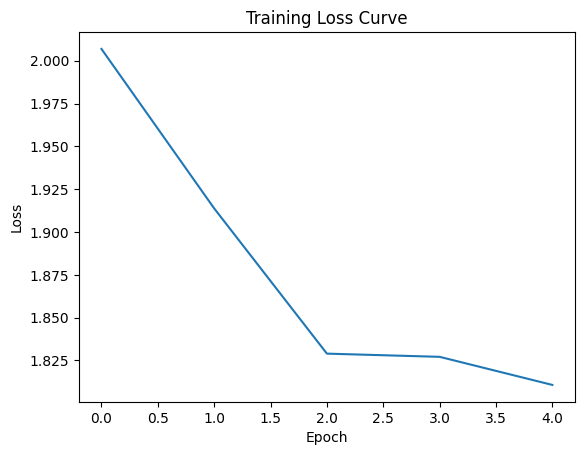

In [10]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [11]:
# Save trained model
import os
os.makedirs('../model', exist_ok=True)
torch.save(model.state_dict(), '../model/best_dermcnn.pth')
print('Model saved to model/best_dermcnn.pth')

Model saved to model/best_dermcnn.pth
